In [1]:
import matplotlib.pyplot as plt
import numpy as np
from config.SC_config_1d import *
from config.config_1d import *
from utils_1d.data_utils import *
from utils_1d.solver_utils import *

In [2]:
## Load models
load_epoch =5000
chkpts_name_c_gen = cwd + '/mdls/' + save_name_c_gen + '_epoch_' + str(load_epoch) + '_ckpt.pth'
ckpt_c = torch.load(chkpts_name_c_gen)
model_c_gen.load_state_dict(ckpt_c)

C:\Users\wzhex\AppData\Local\Temp\ipykernel_38588\2675304089.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_c = torch.load(chkpts_name_c_gen)


<All keys matched successfully>

In [13]:
### Load data
with open(Data_name, 'rb') as ss:
    real = np.load(ss)
    god = np.load(ss)
    lw = np.load(ss)
    cd = np.load(ss)
    fft = np.load(ss)

In [14]:
######### define problem type ###############
type = 'god'
bs = 50
np.random.seed(42)

### metric type: 1 is mmd, 2 is unweighted MELR, 3 is weighted MELR
metric = 3

if metric == 1:
    method = 'mmd'
    weight = False
    Method_name = 'MMD'
elif metric == 2:
    method = 'spectral'
    weight = False
    Method_name = 'MELRu'
elif metric == 3:
    method = 'spectral'
    weight = True
    Method_name = 'MELRw'
elif metric == 4:
    method = 'w2'
    weight = False
    Method_name = 'W2'

# real = real[..., 0]
rows_to_delete = []
for i in range(real.shape[0]):
    if np.max(np.abs(real[i, ...]))<1e-2:
        rows_to_delete.append(i)
        
real = np.delete(real, rows_to_delete, axis=0)
cd = np.delete(cd, rows_to_delete, axis=0)
lw = np.delete(lw, rows_to_delete, axis=0)
fft = np.delete(fft, rows_to_delete, axis=0)
god = np.delete(god, rows_to_delete, axis=0)
real = real[:bs, ...]

if type == 'cd':
    test = cd[:bs, ...]
elif type == 'lw':
    test = lw[:bs, ...]
elif type == 'god':
    test = god[:bs, ...]
elif type == 'fft':
    test = fft[:bs, ...]
elif type == 'white':
    test = real[:bs, ...] + 0.1 * np.random.randn(*real[:bs, ...].shape)
elif type == 'pink':
    test = real[:bs, ...] + 0.1 * generate_batch_pink_noise_1d(bs, real.shape[1])
elif type == 'brown':
    test = real[:bs, ...] + 0.1 * generate_batch_pink_noise_1d(bs, real.shape[1], pinkness=2)

In [15]:
### By vanilla purification
sigma = 0.01
Ts = 0.01
Te = 0.2
t_ls = np.linspace(Ts, Te, 10)
min, t = find_opt_t(test[..., None], real[..., None], marginal_prob_std_fn, t_ls, max_k=64, metric=method, weight=weight, sigma=sigma)


In [16]:
### By imbalance
min, t1, t2 = find_inter_t(test[..., None], real[..., None], marginal_prob_std_fn, t_ls, max_k=64, metric=method, weight=weight, sigma=sigma)


In [17]:
### compute error
Y_test = torch.from_numpy(test[:bs, ..., None]).float().to(device)
real = real[:bs, ..., None]

transfer_sdit_test_imb = transfer_sdit(marginal_prob_std_fn, diffusion_coeff_fn, model_c_gen, Y_test, eps=1e-5, t1=t1, t2=t2)
transfer_sdit_test_vani = transfer_sdit(marginal_prob_std_fn, diffusion_coeff_fn, model_c_gen, Y_test, eps=1e-5, t1=t, t2=t)
# 
# print(transfer_sdit_test_imb.shape, real.shape)
# print(np.min(np.min(np.abs(real), axis=(1,2))))
# print(np.argmin(np.min(np.abs(real), axis=(1,2))))

error_vani2ref_tvd = compute_TVD(transfer_sdit_test_vani, real)
error_imb2ref_tvd = compute_TVD(transfer_sdit_test_imb, real)

print('vanilla t, error are: ', t, error_vani2ref_tvd)
print('imb t_1, t_2, error are: ', t1, t2, error_imb2ref_tvd)

Number of function evaluations: 392
Number of function evaluations: 404
vanilla t, error are:  0.11555555555555555 0.11255784368126408
imb t_1, t_2, error are:  0.03111111111111111 0.0725925925925926 0.06385338802598363


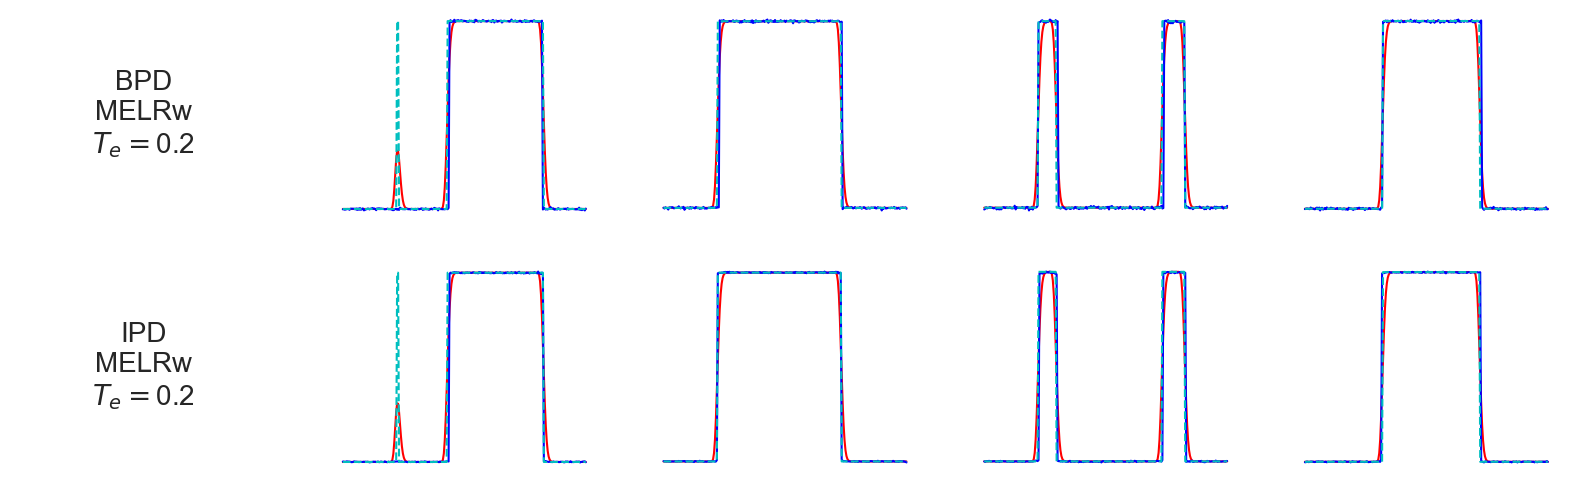

In [18]:
### plot result
bs_plt = 5

fig2, ax = plt.subplots(2, bs_plt, figsize=(bs_plt * 4, 6))
for i in range(1, bs_plt):
    ax[0, i].plot(points, test[i, ...], 'r')
    ax[0, i].plot(points, transfer_sdit_test_vani[i, ..., 0], 'b')
    ax[0, i].plot(points, real[i, ...], 'c--')

    ax[1, i].plot(points, test[i, ...], 'r')
    ax[1, i].plot(points, transfer_sdit_test_imb[i, ..., 0], 'b')
    ax[1, i].plot(points, real[i, ...], 'c--')

ax[0, 0].text(0.5, 0.5, 'BPD\n'+Method_name+'\n'+r'$T_e=$'+str(Te), fontsize=20, ha='center', va='center')
ax[1, 0].text(0.5, 0.5, 'IPD\n'+Method_name+'\n'+r'$T_e=$'+str(Te), fontsize=20, ha='center', va='center')

for axs in ax.flat:
    axs.set_xticks([])
    axs.set_yticks([])
    axs.axis('off')
plt.show()

In [102]:
filename = 'results_1d_' + method + '_' + type + '.npy'
with open(filename, 'wb') as ss:
    np.save(ss, test)
    np.save(ss, real)
    np.save(ss, transfer_sdit_test_vani)
    np.save(ss, transfer_sdit_test_imb)
    
    